In [1]:
%reload_ext autotime
import pandas as pd
import requests
from pprint import pprint
import json
import torch
from PIL import Image
from transformers import MllamaForConditionalGeneration, AutoProcessor

pd.options.plotting.backend = "plotly"
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 100)

df = pd.read_excel("givealittle_health.xlsx")
df.index = pd.to_datetime(df["start"])
df["text"] = df.title.str.cat(df[["pitch", "description", "use_of_funds"]].astype(str), sep=" ")

2024-11-19 13:45:38.210009: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-19 13:45:38.230543: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-19 13:45:38.251121: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-19 13:45:38.257609: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 13:45:38.278330: I tensorflow/core/platform/cpu_feature_guar

In [2]:
model_id = "meta-llama/Llama-3.2-11B-Vision-Instruct"

model = MllamaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
processor = AutoProcessor.from_pretrained(model_id)

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [3]:
sample = df.iloc[0]
sample

title                                             Young mother of 3 recently diagnosed with aggressive breast cancer
pitch                                                        Young mother of three fighting aggresive breast cancer.
hero                     https://static.givealittle.co.nz/assets/hero/e582c9fe-dee8-4746-91bf-b21d00ddf11e-320:False
uri                                             https://givealittle.co.nz/cause/young-mother-of-3-recently-diagnosed
amountRaised                                                                                                  3900.0
goal                                                                                                             0.0
timeLeft                                                                                              181 days to go
action                                                                                                        Donate
actionUri                                https://givealittle.co.

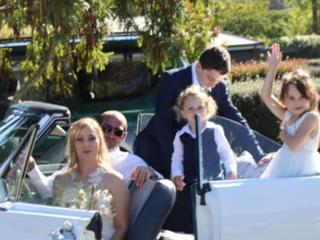

In [4]:
image = Image.open(requests.get(sample.hero, stream=True).raw)
image

In [5]:
messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": "Describe this image: "}
    ]}
]
input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt"
).to(model.device)

output = model.generate(**inputs, max_new_tokens=200)
result = processor.decode(output[0])
print(result[result.rindex("<|end_header_id|>") + len("<|end_header_id|>"):].strip().replace("<|eot_id|>", ""))

The image depicts a family of five, consisting of two adults and three children, posing for a photograph in a white convertible car. The adult woman, dressed in a white dress with a flower bouquet, sits in the front passenger seat, while the adult man, wearing a white shirt and black vest, sits in the driver's seat. Behind them, a man in a dark suit and white shirt stands, with two children, a boy and a girl, positioned behind him. The boy is attired in a white shirt and black vest, while the girl wears a white dress.

In the background, trees and bushes are visible, suggesting that the photo was taken on a sunny day. The overall atmosphere of the image is one of joy and celebration, as the family appears to be enjoying a special moment together.


In [7]:
messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": """
                The below message is text extracted from givealittle, a crowdfunding platform. It's a health related campaign.
                I've also included the hero image for the campaign.
                For the text below, extract the following information, in JSON format:
                condition: the primary health condition mentioned in the text
                ICD10: the ICD10 code for the primary health condition
                name: the name of the person this campaign is for
                gender: the gender of the person this campaign is for
                age: the age of the person this campaign is for
                ethnicity: the ethnicity of the person this campaign is for. If not mentioned in the text, guess their ethnicity from the image.
                urgency: a number from 0-100, indicating how urgent the need is
                sentiment: a number from 0-100, indicating the sentiment of the text, where 100 is the most positive, and 0 is the most negative
                truth: a number from 0-100, indicating how truthful the text is, where 100 is the most truthful, and 0 is the least truthful
                notes: any additional information about how you processed this text, such as warnings or errors

                Do not include comments in your JSON response. Only respond with the JSON object. Do not prefix JSON key names with _. Don't quote numbers.
            """},
            {"type": "image"},
            {"type": "text", "text": sample.text}
        ]
    }
]
input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt"
).to(model.device)

output = model.generate(**inputs, max_new_tokens=200)
result = processor.decode(output[0])
result = json.loads(result[result.rindex("<|end_header_id|>") + len("<|end_header_id|>"):].strip().replace("<|eot_id|>", ""))
pprint(result)

{'ICD10': 'C50',
 'age': 32,
 'condition': 'breast cancer',
 'ethnicity': 'white',
 'gender': 'female',
 'name': 'Amy',
 'notes': 'The ethnicity was guessed from the image, as it is not mentioned in '
          'the text. The image shows a family with fair skin and European '
          'features, suggesting that Amy is likely of European descent.',
 'sentiment': 80,
 'truth': 70,
 'urgency': 90}
